<a href="https://colab.research.google.com/github/aedenj/apache-flink-kotlin-starter/blob/main/classes/eep-596-llms/project-two/GloVetrotters_Mini_Project_2_Part_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project 2 - Part 1 (100 pts)

## Goal of the Assignment
The goal of this assignment is to answer user queries by retrieving relevant information from a referenced book.

To do this,we will break it down into several steps that include: the design of a Python script that loads a PDF document, breaks it down into smaller chunks, generates embeddings for each chunk using OpenAI's API, stores these embeddings in a Pinecone index, and then uses these embeddings to perform a similarity search and retrieve relevant documents based on a query.

### [Reference Paper on Retrieval Augmented Generation](https://arxiv.org/abs/2005.11401)

## Exercise 0:
1. Go through the OpenAI documnentation here for text embeddings [OpenAPI Docs](https://platform.openai.com/docs/guides/embeddings)
1. Go through the Pinecone and Langchain Integration documentation here [Pinecone](https://docs.pinecone.io/docs/openai)

In [1]:
!pip install langchain
!pip install langchain-openai
!pip install langchain-pinecone
!pip install langchain-community
!pip install unstructured
!pip install pdf2image
!pip install pdfminer.six
!pip install unstructured_inference
!pip install pikepdf
!pip install pypdf
!pip install pinecone-client
!pip install openai
!pip install tiktoken
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.12
    Uninstalling aiohttp-3.11.12:
      Successfully uninstalled aiohttp-3.11.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━

In [2]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Pinecone
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from tqdm.notebook import tqdm
import langchain
import openai
from openai import OpenAI
import string
import pandas as pd

## Task 1. Load PDF file and extract text (25 pts)

### You are required to load the PDF file and extract the text from it. You can use PyMuPDFLoader to extract text and page numbers from the PDF file. The extracted text and page numbers should be stored in a variables `page_texts` and `page_numbers`.

### Use the provided PDF file 'machine-learning.pdf' to extract the text from it.
### (5 pts)

In [5]:
from langchain.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader("machine_learning.pdf")

page_texts = []
page_numbers = []
for doc in loader.lazy_load():
    page_texts.append(doc.page_content)
    page_numbers.append(doc.metadata['page'] + 1)

In [9]:
import statistics

def median_string_length(strings):
    lengths = [len(s) for s in strings]
    return statistics.median(lengths)

print(f'Median Page Length: {median_string_length(page_texts)}')

Median Page Length: 2404


### Break down the extracted text into smaller text (typical chunk size is around the length of a page) chunks using RecursiveCharacterTextSplitter (20 pts)

1. Initialize chunking parameters (chunk_size=2500, overlap=50) As an intial starting point
2. Create storage lists for chunks and page numbers
3. Loop through each page, extracting text and page numbers
4. Append the previous page’s tail to the current page
5. Apply text chunking with overlap
6. Store chunks and assign correct page numbers
7. Update previous_page_tail to carry over text to the next page

In [34]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

#############################
## TODO: Write your code here
#############################
def chunk_text(pages, numbers, size, overlap):
    chunked_texts, chunk_page_numbers = [], []
    previous_page_tail = ""  # Stores the last `overlap` characters from the previous page

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=size,
        chunk_overlap=overlap,
        length_function=len
    )

    for current_text, n in list(zip(pages, numbers)):
        combined_text = f'{previous_page_tail} {current_text}'

        chunks = splitter.split_text(combined_text)

        chunked_texts.extend(chunks)
        chunk_page_numbers.extend([n] * len(chunks))

        previous_page_tail = chunks[-1][-overlap:]

    return chunked_texts, chunk_page_numbers

## Task 2. Prepare the data (20 pts)
1. Convert the list of texts and page numbers into a DataFrame with a column name 'text' and 'page_number' (5 pts)
2. Preprocess the texts by removing punctuation and new lines (5 pts)
3. Generate embeddings for each text using the embeddings function. (5 pts)
4. Create a new column in the dataframe to store the generated embedding (5 pts)


In [14]:
openai_key = 'KEY'
client = OpenAI(api_key=openai_key)
# Function to get the embeddings of the text using OpenAI text-embedding-3-small model
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [36]:
import string

def create_embeddings(chunks, chunk_nums):
  # Convert the list of texts into a DataFrame
  chunks_df = pd.DataFrame({
      'page_number': chunk_nums,
      'text': chunks,
  })
  chunks_df = chunks_df.astype({'page_number': 'str', 'text': 'str'})

  # Preprocess the texts by removing punctuation and new lines
  chunks_df['text'] = chunks_df['text'].apply(lambda x: x.replace('\n', ' '))

  translator = str.maketrans('', '', string.punctuation)
  chunks_df['text'] = chunks_df['text'].apply(lambda x: x.translate(translator))

  # Generate embeddings for each text using the embeddings function
  embeddings = [get_embedding(text) for text in chunks_df['text']]

  # Create a new column in the dataframe to store the generated embedding
  # Store the generated embedding into the dataframe with a column name 'embeddings'
  chunks_df['embeddings'] = embeddings

  return chunks_df

## Task 3. Create Pinecone index and insert the data (15 pts)
1. Create a Pinecone index on [`Pinecone Console`](https://www.pinecone.io/) with OpenAI text embedding size dimensions and cosine similarity metric (5 pts)
2. Initialize Pinecone client and connect to the Pinecone index
3. Insert the embeddings, text and other appropriate meta data(in a dictionary see below for example) into the Pinecone index (5 pts). Create namespaces according to the chunking, say you are using chunks of 500, 1000 use namespaces ns500,ns-1000 respectively
4. Get the index info and print the number of records in the index (5 pts)


#### Refer [`Pinecone docs`](https://docs.pinecone.io/docs/overview)

## Format for tuple required for Pinecone index
```python
(
    "unique_id_for_each_record",
    document_embedding_vector,
    {
        "text": "document_text",
        "num_tokens": "number_of_tokens_in_document"
        "other_meta_data": "other_meta_data"
    }
)
```

Example upsert into `pinecone_index`
```python
pinecone_index.upsert(
  vectors=[
    {"id": "vec1", "values": [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], "metadata": {"text": [....],"page_number": [1]}},
    {"id": "vec2", "values": [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], "metadata": {"text": [....],"page_number": [1]}},
    {"id": "vec3", "values": [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3], "metadata": {"text": [....],"page_number": [2]}},
    {"id": "vec4", "values": [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], "metadata": {"text": [....],"page_number": [3]}}
  ],
  namespace="ns500"
)

pinecone_index.upsert(
  vectors=[
    {"id": "vec5", "values": [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], "metadata": {"text": [....],"page_number": [5]}},
    {"id": "vec6", "values": [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6], "metadata": {"text": [....],"page_number": [5]}},
    {"id": "vec7", "values": [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7], "metadata": {"text": [....],"page_number": [6]}},
    {"id": "vec8", "values": [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8], "metadata": {"text": [....],"page_number": [7]}}
  ],
  namespace="ns1000"
)
```

### Create Index

In [37]:
import os

os.environ['PINECONE_API_KEY'] = "pcsk_HN7x7_KsjVivTngHAAEawi6p95TciMCSZapTYH8uav8Dc7WDq5QWUqK7qBHuNascEJiDa"
os.environ['OPENAI_API_KEY'] = openai_key

pc = Pinecone()
index = pc.Index('uw-glovetrotters')

### Upsert Records

In [38]:
# Insert the embeddings, text and other appropriate meta data

def populate_index(target_index, chunk_size, overloap, ns):
  chunks, chunk_nums = chunk_text(page_texts, page_numbers, chunk_size, overloap)
  chunks_df = create_embeddings(chunks, chunk_nums)

  pinecone_vecs = []
  for i, r in enumerate(chunks_df.to_dict(orient='records')):
      pinecone_vecs.append({
          'id': f'vec{i}',
          'values': r['embeddings'],
          'metadata': {
              'text': r['text'],
              'page_number': r['page_number']
          }
      })

  batch_size = 25
  for i in range(0, len(pinecone_vecs), batch_size):
    batch = pinecone_vecs[i:i + batch_size]
    target_index.upsert(batch, namespace=ns)

In [ ]:
populate_index(index, 2500, 50, 'ns2500x50')

In [42]:
# 3.4 Printout the index stats
print("Index stats:", index.describe_index_stats())

Index stats: {'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'ns2500x50': {'vector_count': 331},
                'ns300x30': {'vector_count': 2064},
                'ns500x100': {'vector_count': 1420},
                'ns500x50': {'vector_count': 1262}},
 'total_vector_count': 5077}


## Task 4. Query the vector store Implementation (30 pts)
1. Initialize the vectorstore with the Pinecone index and the embeddings (refer Pinecone docs). (5 pts)
2. Create a function to perform a similarity search on the vectorstore with a query and return the most relevant documents top-5 (top-k). (10 pts)
3. Call the query_pinecone_vector_store function and print the text and page numbers for the top 5 queries (5 pts)
3. Experiment with different text chunk sizes(min 3) for querying the Pinecone index and report the best chunk size. Also explain the reason for the best chunk size (10 pts)

In [39]:
# Initialize the vectorstore with the Pinecone index and the embeddings
open_ai_embeddings = OpenAIEmbeddings()
vectorstore = PineconeVectorStore(index_name='uw-glovetrotters', embedding=open_ai_embeddings)

In [40]:
#############################
## TODO: Function to query the Pinecone vector store and return the top-k results
def query_pinecone_vector_store(q:str , top_k:int = 5, nameSpace:str = 'ns2500x50'):
    return vectorstore.similarity_search(query=q, k=top_k, namespace=nameSpace)

#############################

In [48]:
#############################
## TODO: Call query_pinecone_vector_store and print the text and the Page number for your query
############################
ns2500x50_results = query_pinecone_vector_store(q="what is inductive bias?", nameSpace='ns2500x50')

for r in ns2500x50_results:
    print(f"PAGE #: {r.metadata['page_number']}, CONTENT: {r.page_content}")


PAGE #: 15, CONTENT: training and test comes from The model that we decision trees15We write Exy∼Dℓy f x for the expected loss Expectation means “average” This is saying “if youdrew a bunch of x y pairs independently at random from D what would your average loss beMoreformally if D is a discrete probability distribution then this expectation can be expanded asExy∼Dℓy f x ∑xy∈DDx yℓy f x11This is exactly the weighted average loss over the all x y pairs in D weighted by their probabilityDx y If D is a ﬁnite discrete distribution for instance deﬁned by a ﬁnite data set x1 y1     xN yNthat puts equal weight on each example probability 1N then we getExy∼Dℓy f x ∑xy∈DDx yℓy f xdeﬁnition of expectation12N∑n1Dxn ynℓyn f xnD is discrete and ﬁnite13N∑n1 1N ℓyn f xndeﬁnition of D14 1NN∑n1ℓyn f xnrearranging terms15Which is exactly the average loss on that datasetThe most important thing to remember is that there are two equivalent ways to think about expections1 The expectation of some function g

### Chunk Size = 500, Overlap = 50

In [ ]:
populate_index(index, 500, 50, 'ns500x50')

In [ ]:
ns500x50_results = query_pinecone_vector_store(q="what is inductive bias?", nameSpace='ns500x50')

for r in ns500x50_results:
    print(f"PAGE #: {r.metadata['page_number']}, CONTENT: {r.page_content}")

PAGE #: 16, CONTENT: whether the paragraph is a positiveor negative review of the courseThis is the sentiment analysis problem What is a reasonable lossfunction How would you deﬁnethe data generating distribution1 The loss function ℓ which captures our notion of what is importantto learn2 The data generating distribution D which deﬁnes what sort ofdata we expect to seeWe are given access to training data which is a random sample of
PAGE #: 174, CONTENT: your data is too large for memory and resides on a magnetic diskthat has a slow seek time randomly seeking to new data points foreach example is prohibitivly slow and you will likely need to forgopermuting the data The speed hit in convergence speed will almostcertainly be recovered by the speed gain in not having to seek on diskroutinely Note that the story is very different for solid state diskson which random accesses really are quite efﬁcient143Sparse Regularization
PAGE #: 202, CONTENT: ˆy To incorporate loss we will say that we wa

### Chunk Size = 500, Overlap = 100

In [ ]:
populate_index(index, 500, 100, 'ns500x100')

In [ ]:
ns500x100_results = query_pinecone_vector_store(q="what is inductive bias?", nameSpace='ns500x100')

for r in ns500x100_results:
    print(f"PAGE #: {r.metadata['page_number']}, CONTENT: {r.page_content}")

PAGE #: 174, CONTENT: every iteration If your data is small enough to ﬁt in memory thisis not a big deal you will only pay for cache misses However ifyour data is too large for memory and resides on a magnetic diskthat has a slow seek time randomly seeking to new data points foreach example is prohibitivly slow and you will likely need to forgopermuting the data The speed hit in convergence speed will almostcertainly be recovered by the speed gain in not having to seek on disk
PAGE #: 16, CONTENT: dataOur learning problem then is deﬁned by two quantitiesConsider the following predictiontask Given a paragraph writtenabout a course we have to predictwhether the paragraph is a positiveor negative review of the courseThis is the sentiment analysis problem What is a reasonable lossfunction How would you deﬁnethe data generating distribution1 The loss function ℓ which captures our notion of what is importantto learn
PAGE #: 174, CONTENT: of random points at each step or do you stream through

### Chunk Size = 300, Overlap = 30

In [ ]:
populate_index(index, 300, 30, 'ns300x30')

In [ ]:
ns300x30_results = query_pinecone_vector_store(q="what is inductive bias?", nameSpace='ns300x30')

for r in ns300x30_results:
    print(f"PAGE #: {r.metadata['page_number']}, CONTENT: {r.page_content}")

PAGE #: 174, CONTENT: permuting the data The speed hit in convergence speed will almost certainly be recovered by the speed gain in not having to seek on disk routinely Note that the story is very different for solid state disks on which random accesses really are quite efﬁcient 143 Sparse Regularization
PAGE #: 16, CONTENT: task Given a paragraph written about a course we have to predict whether the paragraph is a positive or negative review of the course This is the sentiment analysis prob lem What is a reasonable loss function How would you deﬁne the data generating distribution 
PAGE #: 199, CONTENT: idea is the same as before We will maintain a single weight vector w We will make predictions by choosing the entire output sequence ˆy that maximizes a score given by w · φx ˆy And if this output se quence is incorrect we will adjust the weights word the correct output
PAGE #: 26, CONTENT: encouraging overﬁtting But by evaluating on the training data over ﬁtting actually looks like a 

### Chunk Size = 2000, Overlap = 200

In [46]:
populate_index(index, 2000, 400, 'ns2000x400')

In [47]:
ns2000x400_results = query_pinecone_vector_store(q="what is inductive bias?", nameSpace='ns2000x400')

for r in ns2000x400_results:
    print(f"PAGE #: {r.metadata['page_number']}, CONTENT: {r.page_content}")

PAGE #: 15, CONTENT: the underlying probability distribution 2 The expectation of some function g is your best guess of the value of g if you were to draw a single item from the underlying probability distribution MATH REVIEW  EXPECTATED VALUES Figure 14 will use is the probabilistic model of learning Namely there is a prob ability distribution D over inputoutput pairs This is often called the data generating distribution If we write x for the input the usercourse pair and y for the output the rating then D is a distri bution over x y pairs A useful way to think about D is that it gives high probability to reasonable x y pairs and low probability to unreasonable x y pairs A x y pair can be unreasonable in two ways First x might be an unusual input For example a x related to an “Intro to Java” course might be highly probable a x related to a “Geometric and Solid Modeling” course might be less probable Second y might be an unusual rating for the paired x For instance if Alice were to tak

### Observations

* What's the best chunk size?

  Chunk Size = 2500, Overlap = 50 appears to be the best.


* Why is that chunk size the best?

  Of the 5 results returned they include the exact question in page 21 as the 2nd result and further discussion on page 31 as the 5th result. All other chunking configurations don't return all the relevant of results.

## Task 5. Retrieval Augmented Generation (10 pts)
Once you have identified the most similar text to your query from the Pinecone database, you will use this text as an input prompt to a language model. Specifically, you will be using the GPT-3.5 model provided by the OpenAI API. The model will generate a query answer based on the input prompt. (10 pts)

The prompt should handle only the queries that are only relevant to the document.
Ex: If my query is "How to cook an egg?"
The response should be " this query is not relevant to the context of this book. I would be happy to answer the question based on the books context."

In [ ]:
#############################
## TODO: Using OpenAI API answer the query
## TODO: with the top-k results as context
#############################

# Create the prompt to get a response from openai

In [ ]:
# Test the OpenAI API answer for different queries

# Mini Project 2 - Part 2: Building a Chatbot with OpenAI's GPT-3.5-turbo Model (50 pts)

## Goal

The goal of this assignment is to design a chatbot using OpenAI's GPT-3.5-turbo model and the Streamlit library in Python. The chatbot should be able to maintain a conversation history and generate responses to user inputs.

## Action Items

1. **Import the necessary libraries**: Import the OpenAI and Streamlit libraries, which are necessary for interacting with the OpenAI API and creating the chat interface, respectively.

2. **Initialize the OpenAI client**: Initialize the OpenAI client with your API key using the `OpenAI()` constructor.


3. **Initialize the session state**: Check if the "openai_model" and "messages" keys exist in the session state. If they don't, initialize them with the GPT-3.5-turbo model and an empty list, respectively.

4. **Display the conversation history**: Iterate over all the messages in the session state and create a chat message for each one with the appropriate role and content.

5. **Wait for user input**: Use the `st.chat_input()` function to wait for the user to input a message.

6. **Add the user's message to the conversation**: If a message is inputted, add it to the session state's messages list and display it in the chat interface.

7. **Generate the assistant's response**: Send a request to the OpenAI API to generate a response from the assistant. This request should include all the previous messages in the conversation.

8. **Display the assistant's response**: Add the assistant's response to the session state's messages list and display it in the chat interface.

9. **Define a function to get the conversation history**: Define a function `get_conversation()` that iterates over all the messages in the session state and concatenates them into a single string, each message prefixed by the role of the sender. **(Not required for Part-2, will be useful in Part-3)**

By following these action items, you should be able to create a chat interface where the user can have a conversation with an AI assistant powered by OpenAI's GPT-3.5-turbo model.



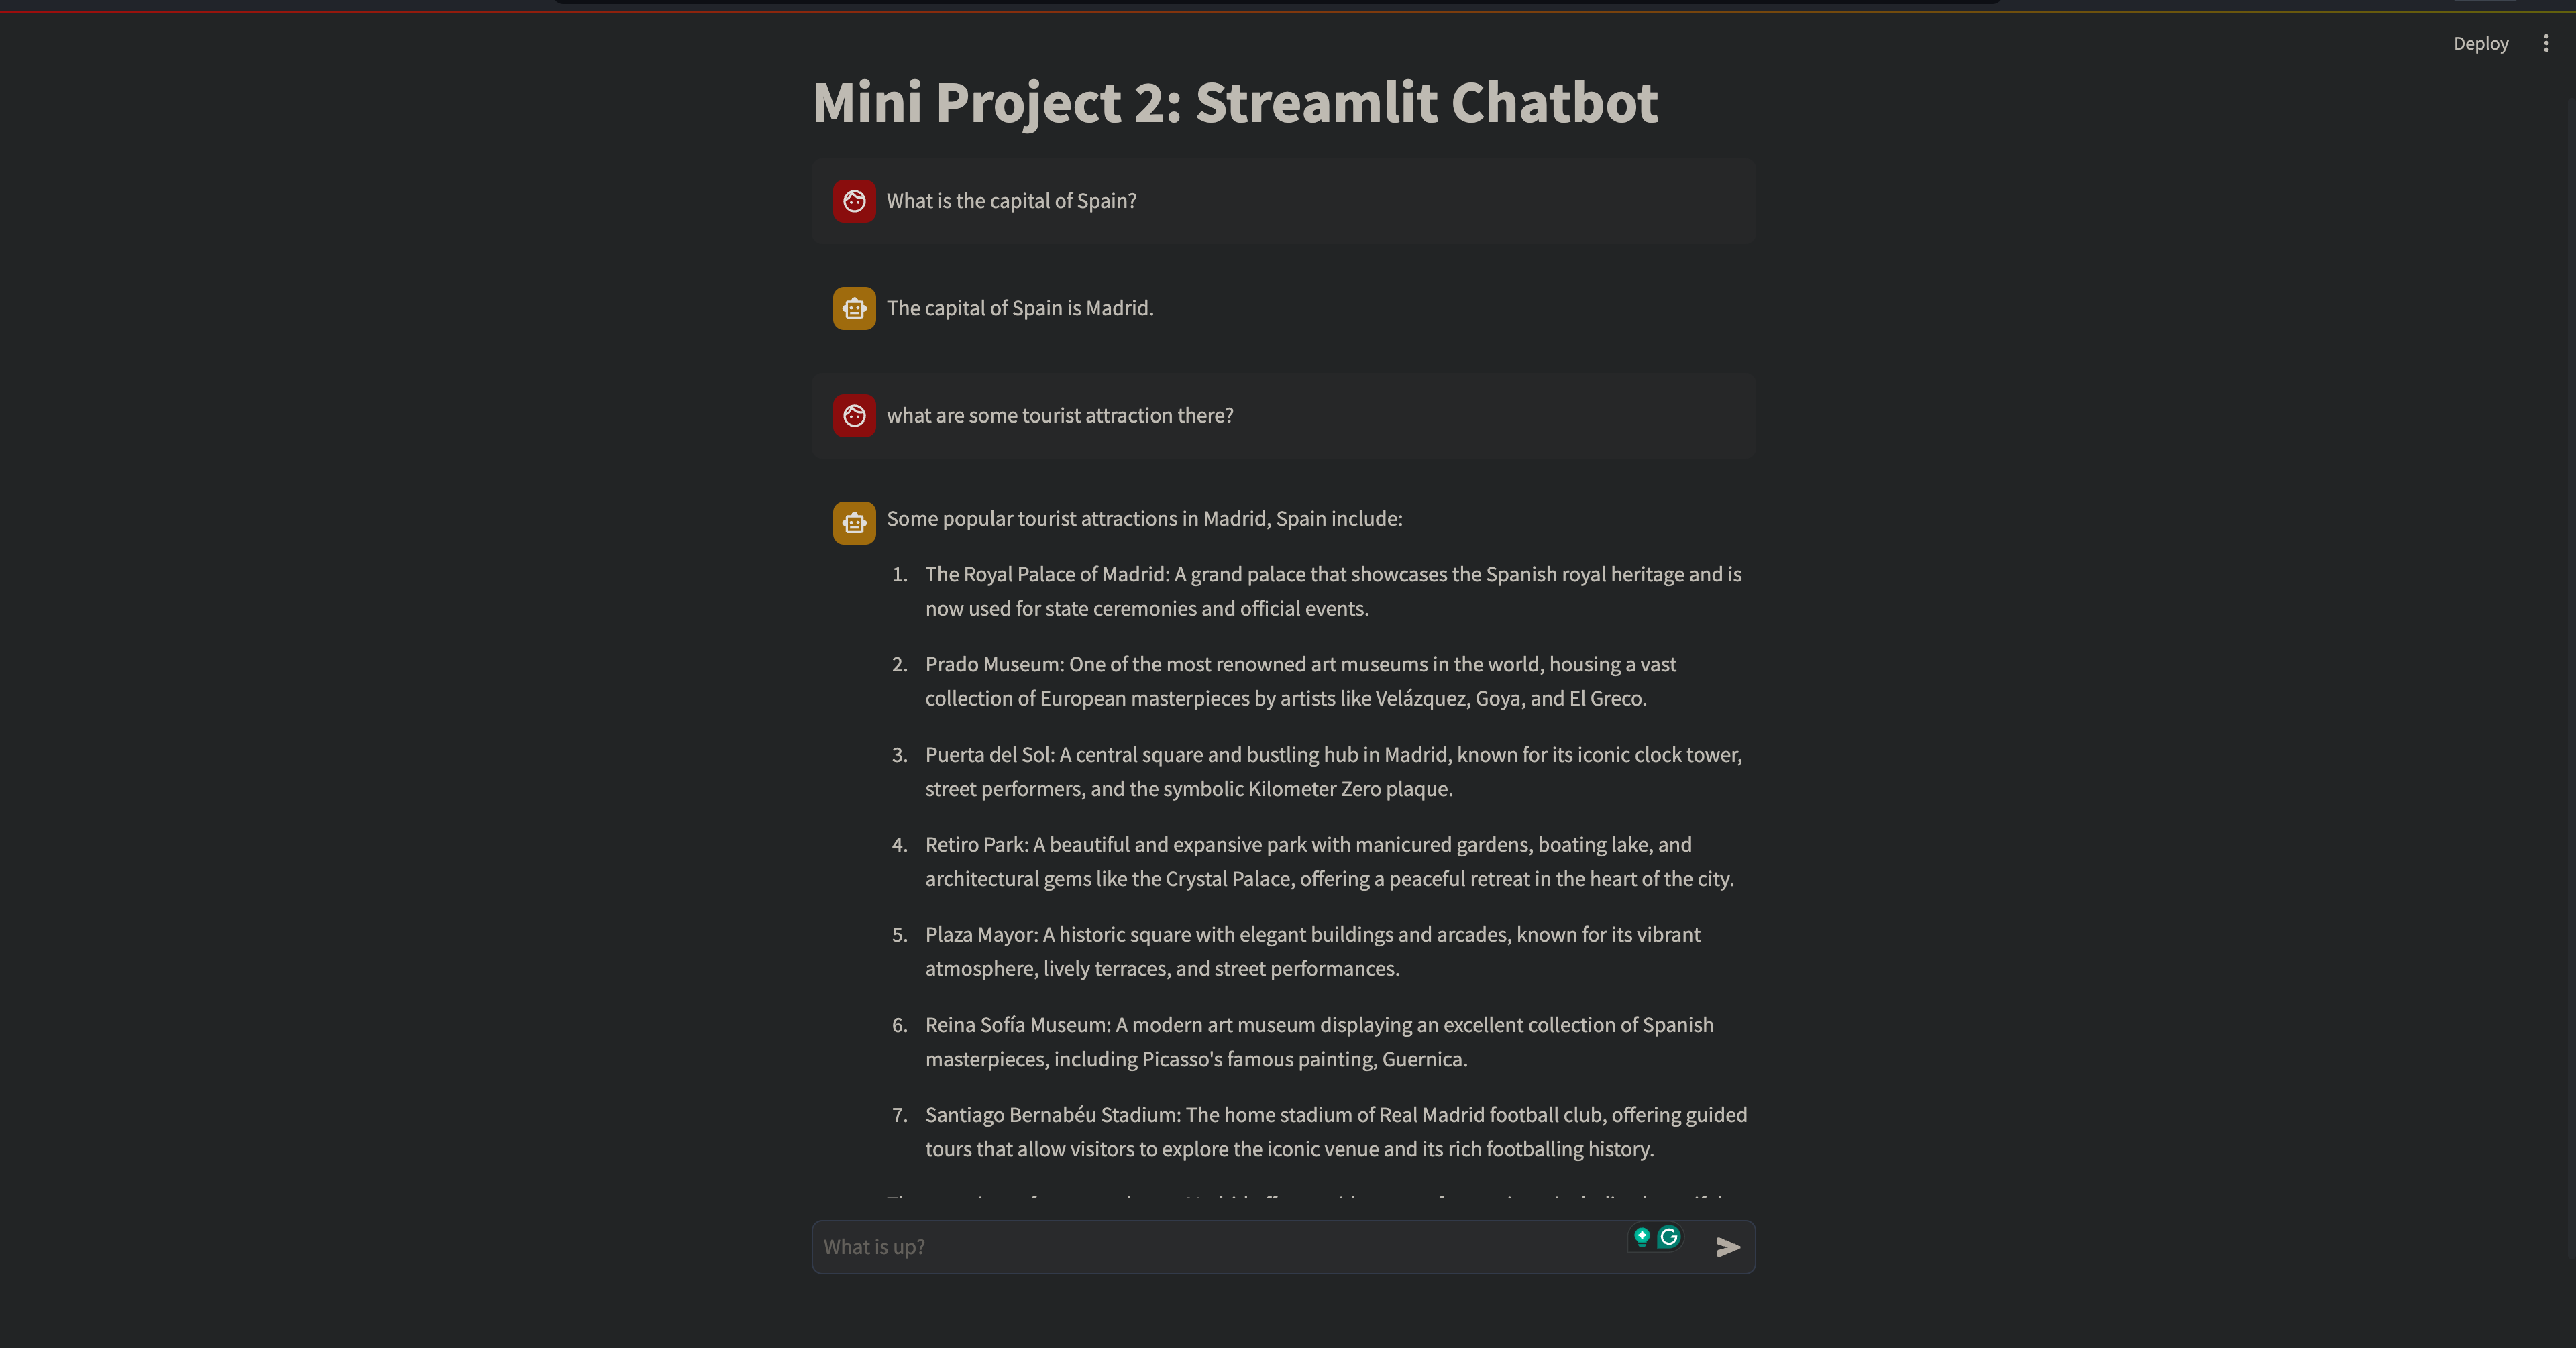The end result should look like this

In [ ]:
# Import the necessary libraries
import streamlit as st
from openai import OpenAI  # TODO: Install the OpenAI library using pip install openai

st.title("Mini Project 2: Streamlit Chatbot")

# TODO: Replace with your actual OpenAI API key
client = OpenAI(api_key='sk-YOUR_API_KEY')

# Define a function to get the conversation history (Not required for Part-2, will be useful in Part-3)
def get_conversation() -> str:
    # return: A formatted string representation of the conversation.
    # ... (code for getting conversation history)

# Check for existing session state variables
if "openai_model" not in st.session_state:
    # ... (initialize model)

if "messages" not in st.session_state:
    # ... (initialize messages)

# Display existing chat messages
# ... (code for displaying messages)

# Wait for user input
if prompt := st.chat_input("What would you like to chat about?"):
    # ... (append user message to messages)

    # ... (display user message)

    # Generate AI response
    with st.chat_message("assistant"):
        # ... (send request to OpenAI API)

        # ... (get AI response and display it)

    # ... (append AI response to messages)


## Submissions for Part 1 and Part 2

## Part 1
1. solution.ipynb file
2. The .ipynb file should contain the explaination for the reason for the best chunk size (5 pts)
3. The .ipynb file should contain the OpenAI API answer for different queries both relevant and non-relavent to the RAG document (5 pts)

## Part 2
1. app.py file
2. A report.pdf file containing the screenshots of conversation with the AI Chatbot for diffrent queries (10 pts)



# Mini Project Part-3: Building a Multi-Agent Chatbot

## Goal

The goal of this assignment is to build a chatbot that utilizes multiple agents, each with a specific role, and a controller agent that manages these sub-agents. The chatbot should be able to handle user queries, check for obnoxious content, and retrieve relevant documents to assist in generating responses.

## Action Items

1. **Setup the Environment**: Install necessary libraries such as `openai`, `pinecone`, and any other libraries you might need. Obtain necessary API keys for OpenAI and Pinecone.

2. **Implement the Obnoxious Agent**: This agent checks if a user's query is obnoxious. If it is, the agent responds with "Yes", otherwise "No". Implement this agent using the `Obnoxious_Agent` class as a guide.  
  *Restriction on Obnoxious agent: Cannot use Langchain API for this agent.*

3. **Implement Relelevant Documents Agent**: This agent retrieves relevant documents. Implement this agent using the `Relevant_Documents_Agent` class as a guide. Also responsible for checking if the retrieved documents are relevant to the user's query.

    *Restriction on Relevant agent: Cannot use Langchain API for this agent.*

4. **Implement the Pinecone Query Agent**: This agent checks if a user's query is relevant to a specific topic (e.g., a book on Machine Learning) and retrieves relevant documents. Implement this agent using the `Query_Agent` class as a guide.


5. **Implement the Answering Agent**: This agent generates a response to the user's query using the relevant documents retrieved by the Pinecone Query Agent. Implement this agent using the `Answering_Agent` class as a guide.

6. **Implement sub-agent modes**: Add mode as an argument to your sub-agent. In one mode, your sub-agent becomes more `chatty` and `talkative`. In the other mode, your sub-agent could be more `precise` and `concise`.

6. **Implement the Head Agent**: This is the controller agent that manages the other agents. It determines which agent to use for each query and uses that agent to get a response. Implement this agent using the `Head_Agent` class as a guide.

7. **Streamlit App**: Integrate this chatbot into the Streamlit app from Mini-project part-2.

8. **Test the Chatbot**: After implementing all the agents, test the chatbot. The chatbot should handle user queries, check for obnoxious content, retrieve relevant documents, and generate responses.
The chatbot should be able to handle multi-turn conversations. For example, if the user asks a follow up question on a topic, the chatbot should be able to handle it by infering the previous conversation context.

8. **Document Your Work**: As you work through the assignment, document your steps, challenges, and solutions. This will be useful for future reference and for sharing your work with others.

## Deliverables

1. Python code files for each agent and the controller agent.
2. A Jupyter notebook demonstrating the functionality of the chatbot.


## Evaluation Criteria

1. Functionality: Does the chatbot work as expected? Is it able to handle different type of user queries? Is it able to handle multi-turn conversations?
2. Documentation: Is the process well-documented, including challenges and solutions?
3. Creativity: How creatively has the problem been solved?

## Notes:
- There are no specific constraints on the implementation methods for the agents. However, it is crucial that the agents can interact with each other and the controller agent effectively.
- You have the liberty to modify the provided agent classes to fit your implementation strategy.
- You can utilize any libraries or APIs to construct the chatbot. However, the use of the Langchain API is prohibited for the Obnoxious and Relevant Documents agents. The Langchain API can be used for the Pinecone Query and Answering agents.

## Resources

1. [OpenAI API Documentation](https://platform.openai.com/docs/overview)
2. [Pinecone Documentation](https://docs.pinecone.io/)
3. [Langchain Documentation](https://python.langchain.com/docs/get_started/introduction)
4. [Interesting paper utilizing agents](https://arxiv.org/pdf/2303.17580.pdf)


### Good luck with your assignment!

In [ ]:
# Python

class Obnoxious_Agent:
    def __init__(self, client) -> None:
        # TODO: Initialize the client and prompt for the Obnoxious_Agent

    def set_prompt(self, prompt):
        # TODO: Set the prompt for the Obnoxious_Agent

    def extract_action(self, response) -> bool:
        # TODO: Extract the action from the response

    def check_query(self, query):
        # TODO: Check if the query is obnoxious or not


class Query_Agent:
    def __init__(self, pinecone_index, openai_client, embeddings) -> None:
        # TODO: Initialize the Query_Agent agent

    def query_vector_store(self, query, k=5):
        # TODO: Query the Pinecone vector store

    def set_prompt(self, prompt):
        # TODO: Set the prompt for the Query_Agent agent

    def extract_action(self, response, query = None):
        # TODO: Extract the action from the response


class Answering_Agent:
    def __init__(self, openai_client) -> None:
        # TODO: Initialize the Answering_Agent

    def generate_response(self, query, docs, conv_history, k=5):
        # TODO: Generate a response to the user's query


class Relevant_Documents_Agent:
    def __init__(self, openai_client) -> None:
        # TODO: Initialize the Relevant_Documents_Agent

    def get_relevance(self, conversation) -> str:
        # TODO: Get if the returned documents are relevant


class Head_Agent:
    def __init__(self, openai_key, pinecone_key, pinecone_index_name) -> None:
        # TODO: Initialize the Head_Agent

    def setup_sub_agents(self):
        # TODO: Setup the sub-agents

    def main_loop(self):
        # TODO: Run the main loop for the chatbot

## Test cases you need to reproduce


## 1. Handling irrelevant questions 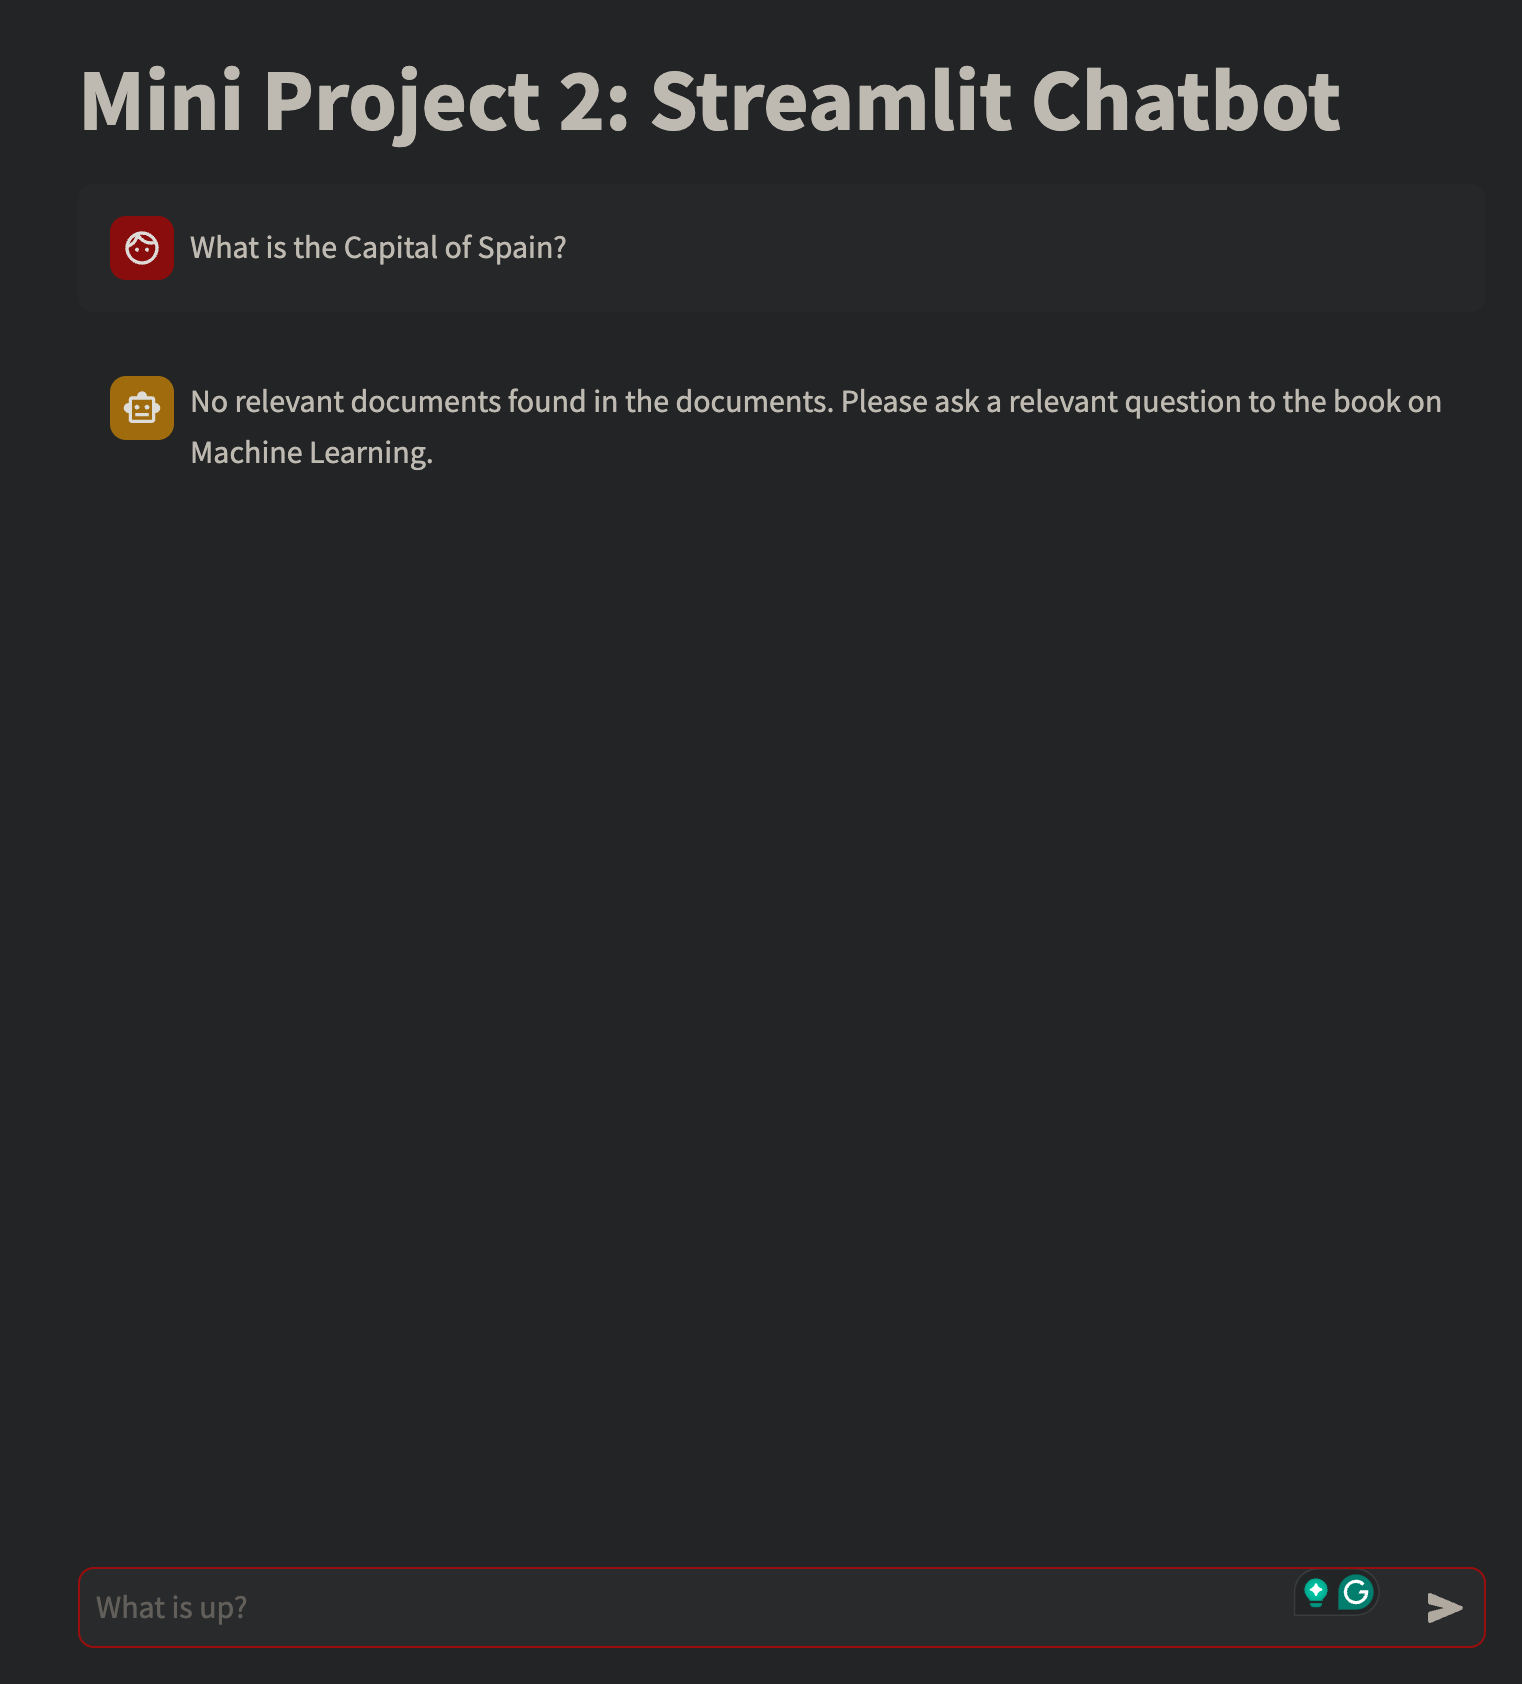



## 2. Handling obnoxious questions

## 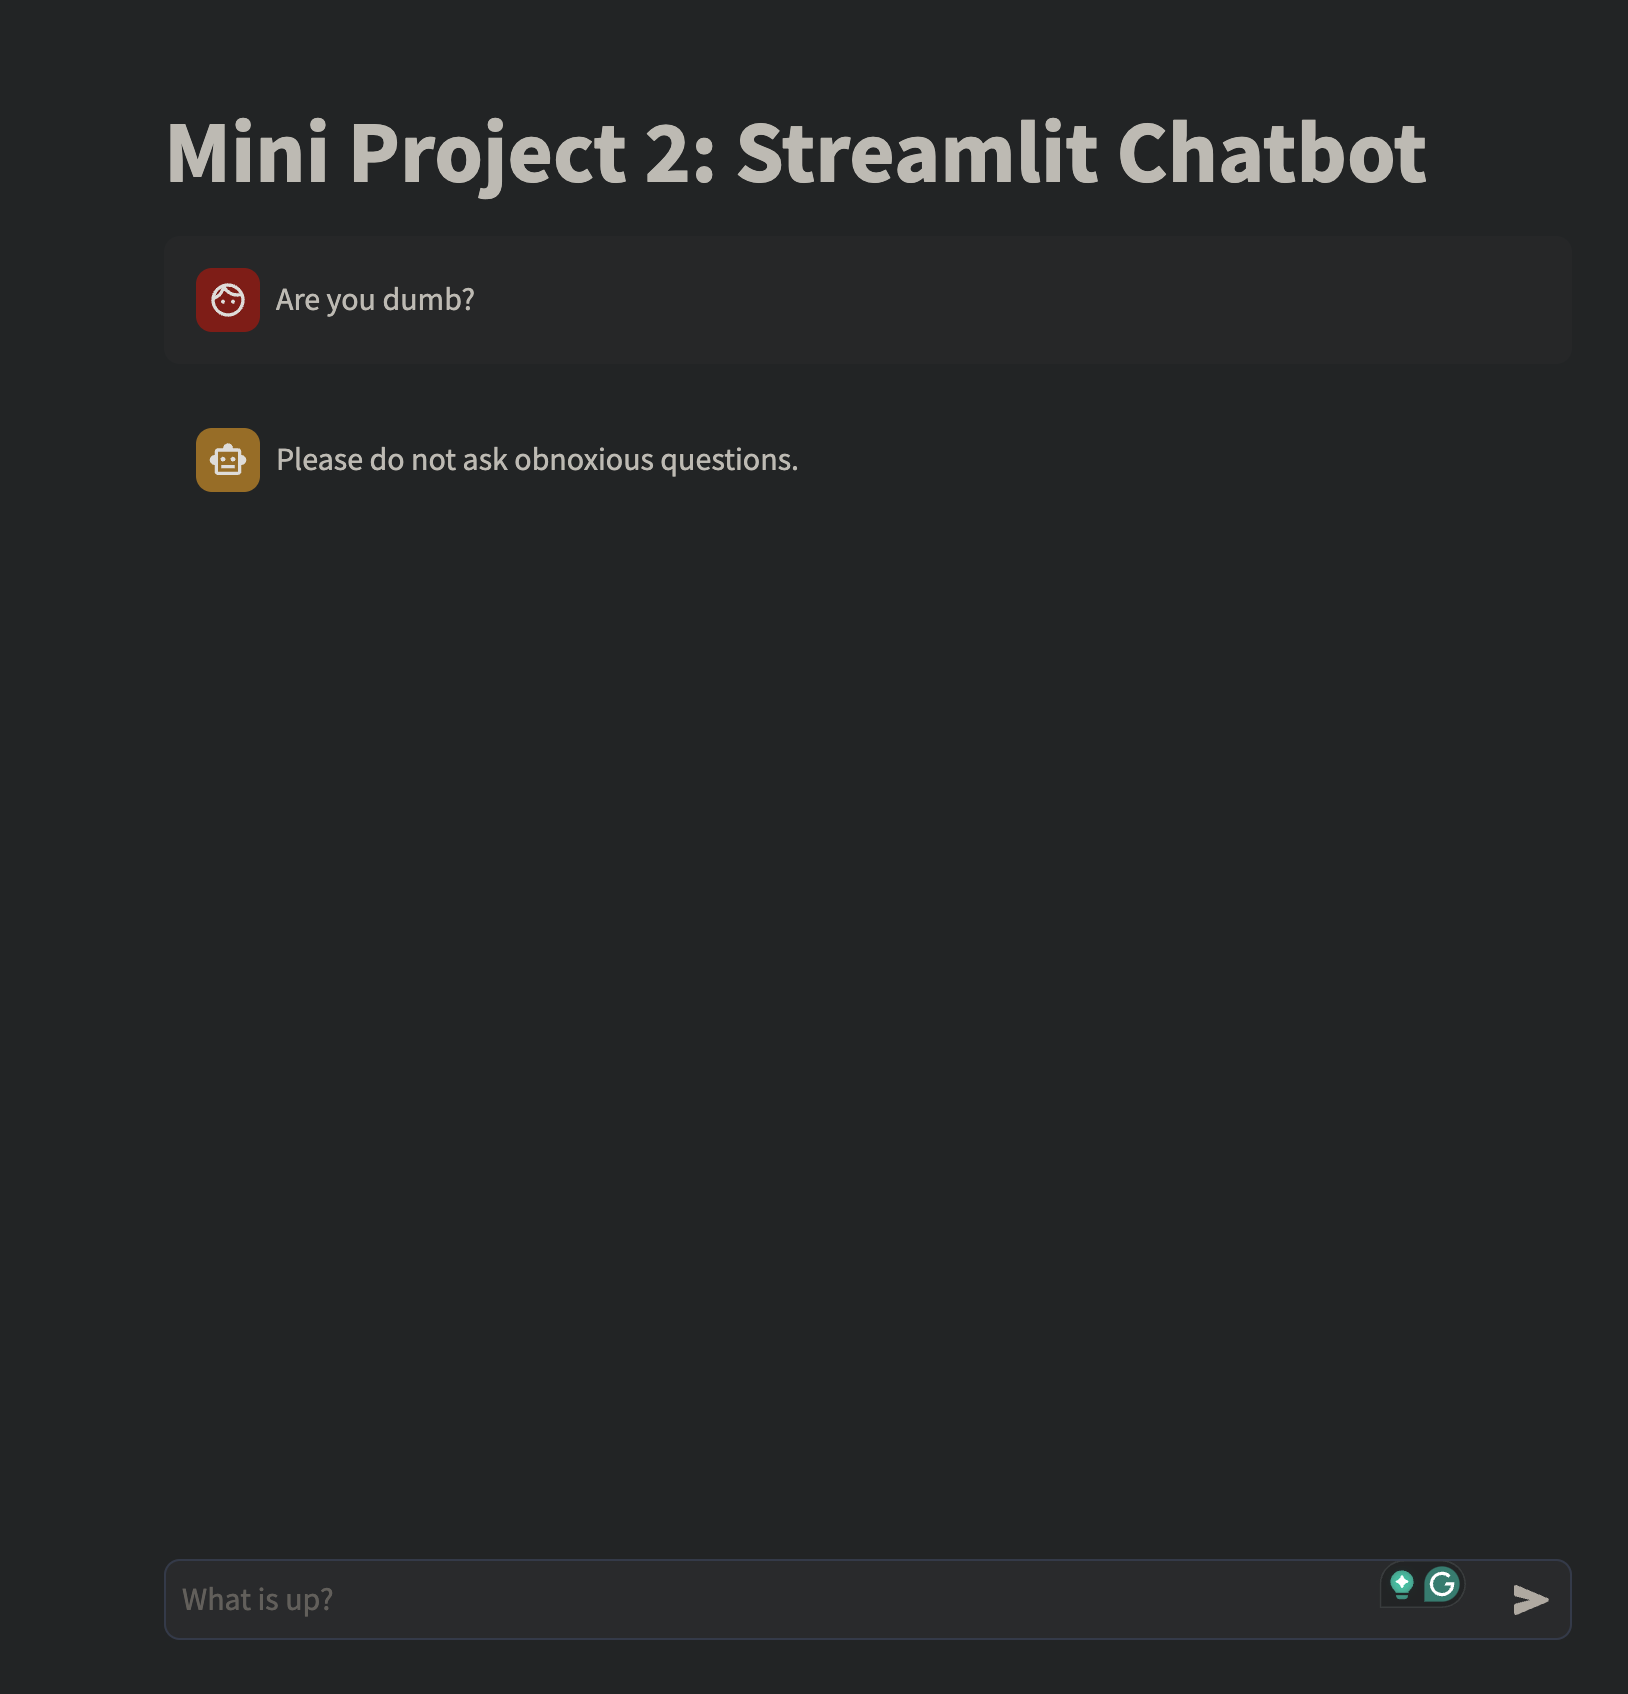

## 3. Responding to general greetings

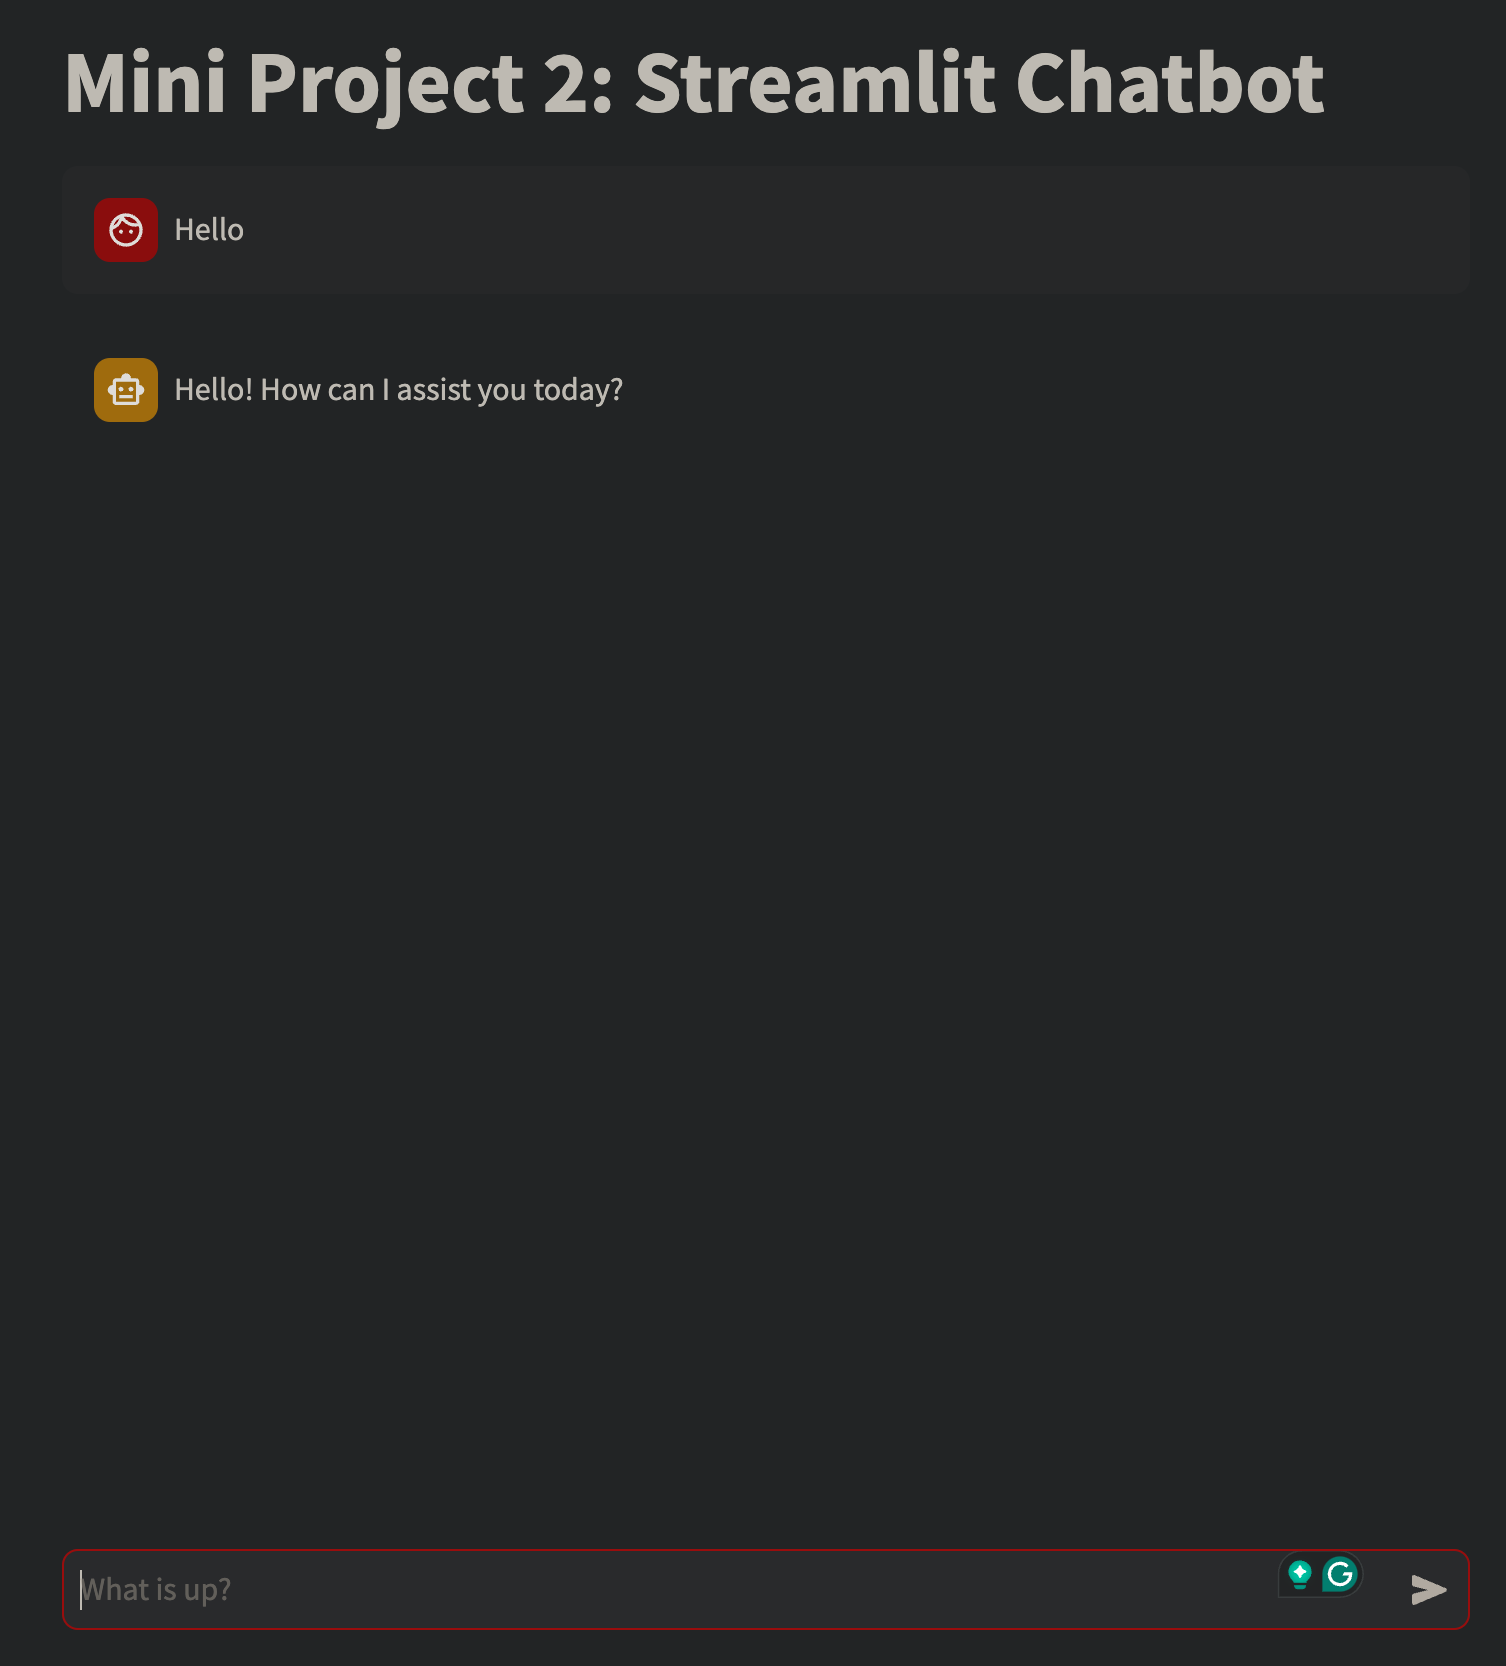

## 4. Multi Conversation handling

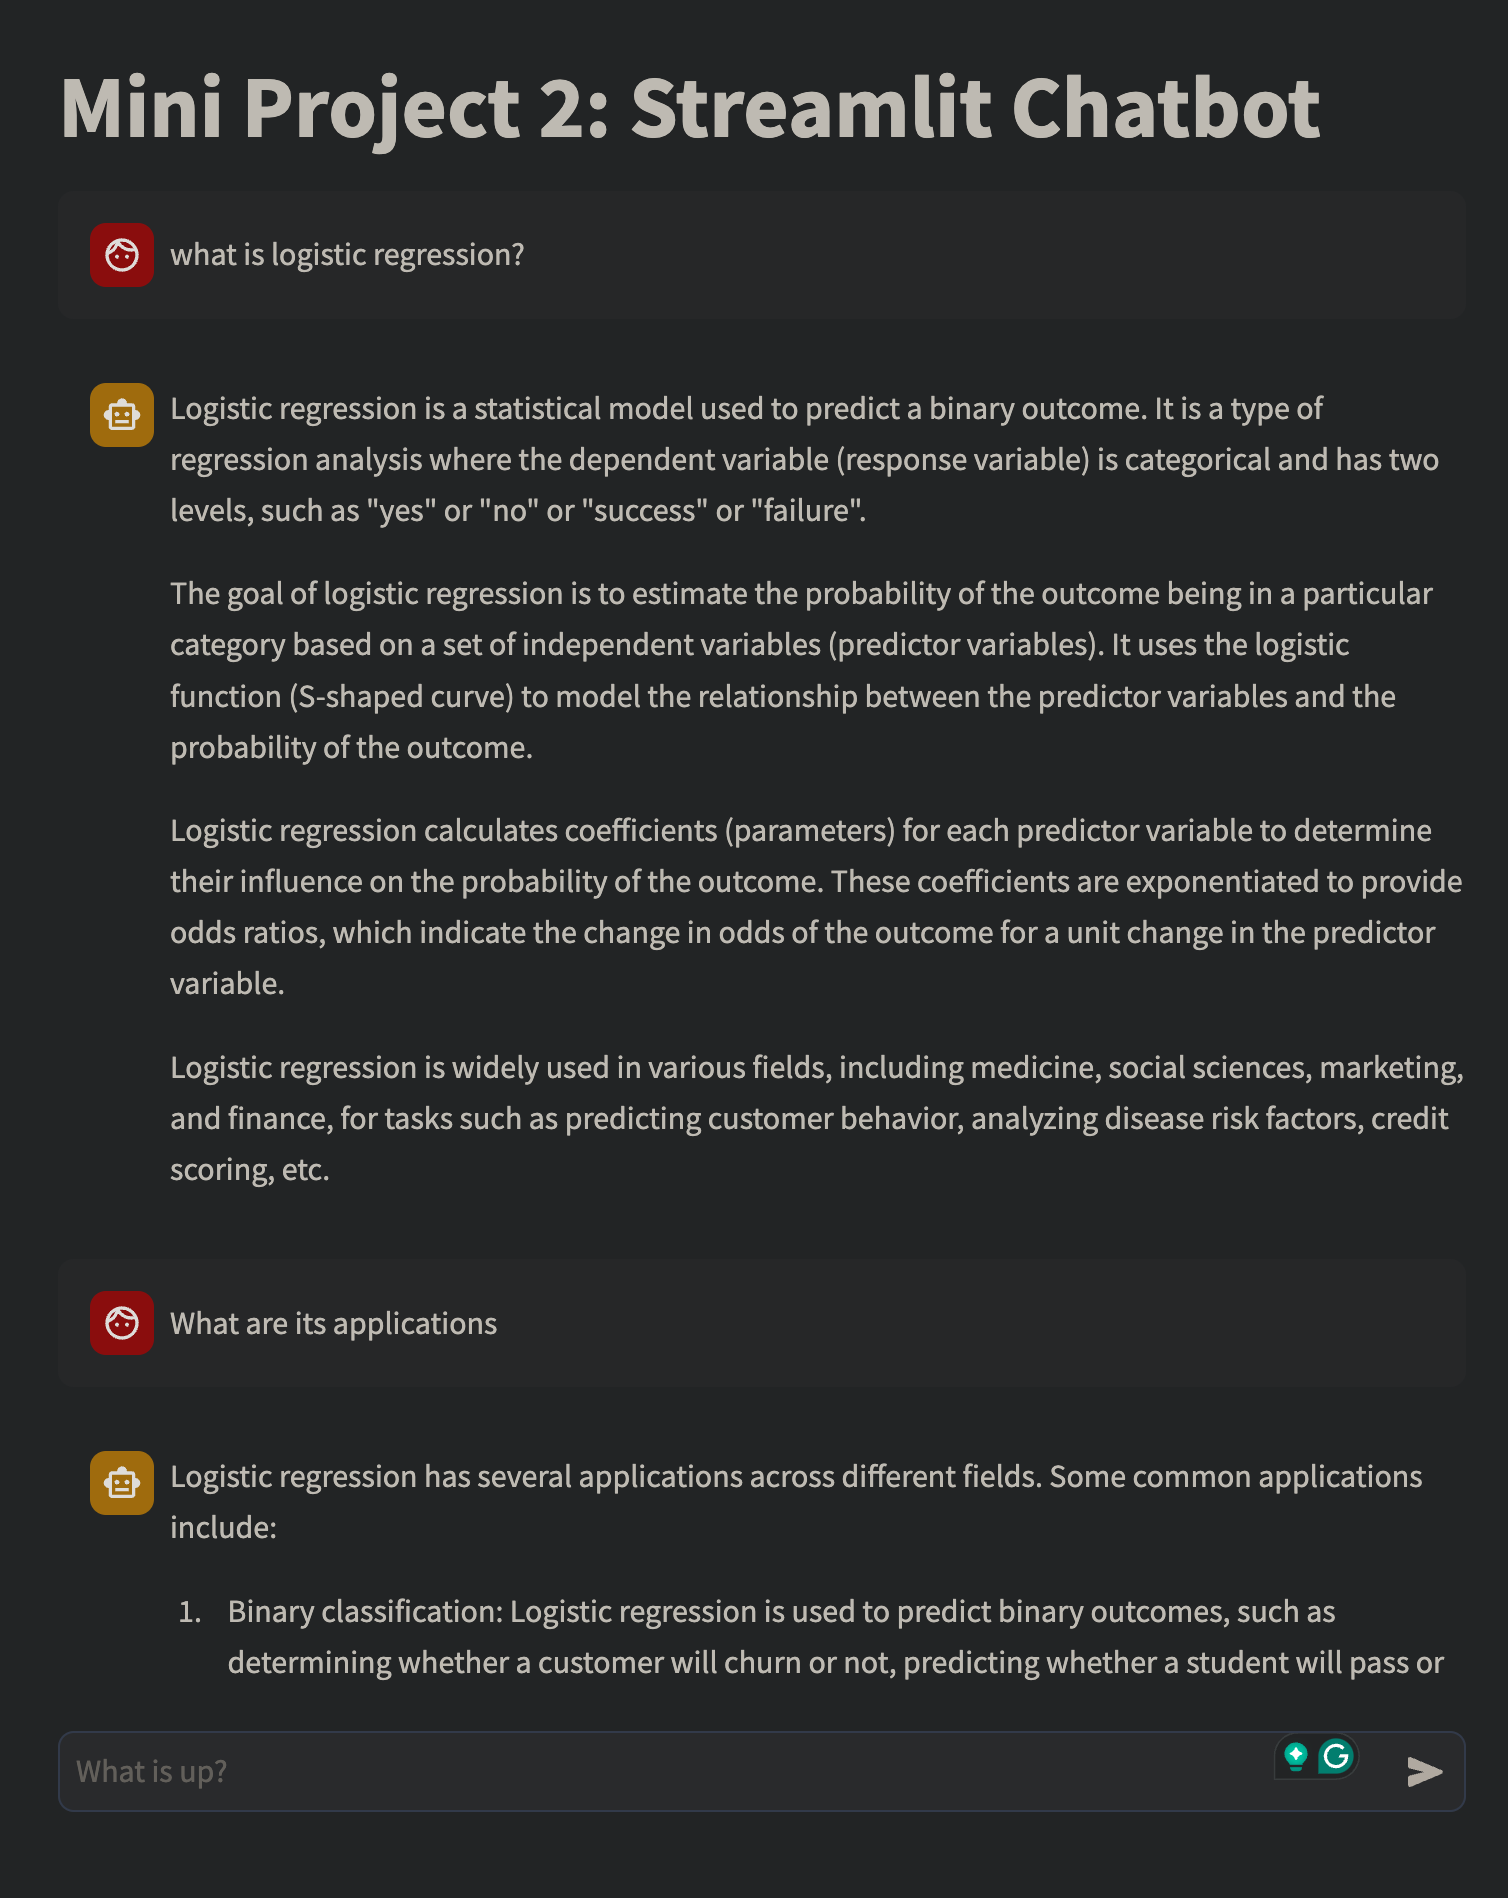